# <div style="text-align: center"> Python (The heart of AI program)

## <div style="text-align: center">Final Project: Image Classification

## <div style="text-align: center">Author: Jose Caloca

# <div style="text-align: center"> 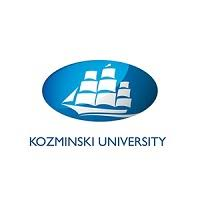

---

# Introduction

This is a final project for the Python (The heart of AI program) by Kozminski University under the Spinaker Programme. The objective of this study is to create a neural network that classifies pictures of cats and dogs and try to obtain the largest accuracy as possible, while at the same time avoiding overfitting in the model so that it can provide robust results across different input data.

The dataset use is from the kaggle competition **Dogs vs. Cats Redux: Kernels Edition** [click here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) to have access to the competition and data. 

For this a **Convolutional Neural Network (CNN)** will be trained. The main advantage of neural networks lies in their ability to outperform nearly every other machine learning algorithm, but this comes with some disadvantages. Mainly, one of the biggest dissadvantages is that CNN are more computationally expensive than traditional algorithms. State of the art deep learning algorithms, which realize successful training of really deep neural networks, can take several weeks to train completely from scratch. By contrast, most traditional machine learning algorithms take much less time to train, ranging from a few minutes to a few hours or days. Since the training time heavility depends on the size of the data and the complexity of the CNN we decided to train this model cloud. More especifically, in **Google Cloud Platform** we run a instance (virtual machine) with some characteristics: higher CPU and an NVIDIA GPU card for tensorflow. This machine runs in **VertexAI**, more specifically in WorkbechAI using notebooks, also the machine was set with **Tensorflow entreprise 2.6 machine learning framework**.

Results and further insights are found further in this notebook.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import os
import cv2
import tensorflow as tf
from random import shuffle
from keras.layers import Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from skimage import io
import opendatasets as od
import zipfile
from imports_for_ML_P32 import load_images

## Load dataset

The dataset was directly downloaded from Kaggle by accesing via the API and having in the working directory a json file with the API key.

In [2]:
od.download('https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition')

100%|██████████| 814M/814M [00:06<00:00, 125MB/s]  



Extracting archive ./dogs-vs-cats-redux-kernels-edition/dogs-vs-cats-redux-kernels-edition.zip to ./dogs-vs-cats-redux-kernels-edition


Then we un-zip the files and load all pictures in the **train** folder with 25000 pictures. 50% of those are pictures of cats and the remaining 50% of dogs

In [3]:
with zipfile.ZipFile('./dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [4]:
# Set directory for loading the dataset
train_img_dir = r'train'
train_images = os.listdir(train_img_dir)
# getting individual image directory
full_training_images = [os.path.join(train_img_dir, img) for img in train_images]

There is indeed a problem of misslabelling the dataset. The following images are labelled as **CATS** but one is a random men, and the other picture is a dog. In order to avoid bias in the model we will impute this pictures by exclusing them from the training:  

In [5]:
idx = np.where(pd.Series(full_training_images).str.contains('cat.7377.jpg') == True)
idx2 = np.where(pd.Series(full_training_images).str.contains('cat.4085.jpg') == True)

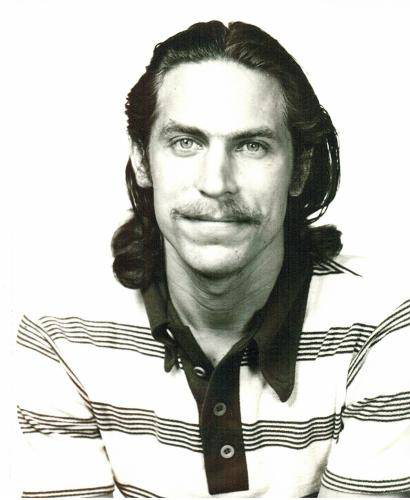

In [6]:
load_img(full_training_images[idx[0][0]])

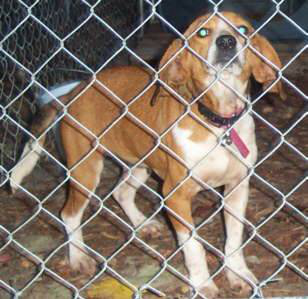

In [7]:
load_img(full_training_images[idx2[0][0]])

In [8]:
os.remove(full_training_images[idx[0][0]])
os.remove(full_training_images[idx2[0][0]])

After removing the noisy pictures, we load them and as a form of a numpy array using OpenCV which is a Python bindings designed to solve computer vision problems. We set the number of pixels to 90 so that it won't take much space in the RAM memory and will be easier for training

In [9]:
def load_images(img_dir, n_images=1000, resize=(50, 50)):
    '''
    Load images of cats and dogs and organize into sklearn-like format.
    '''
    try:
        from keras.preprocessing.image import load_img, img_to_array
    except:
        from tensorflow.keras.preprocessing.image import load_img, img_to_array

    images = os.listdir(img_dir)
    czy_pies = np.array(['dog' in img for img in images])
    n_per_categ = n_images // 2

    n_stars = 0
    imgs, y = list(), list()
    for flt_idx, flt in enumerate([~czy_pies, czy_pies]):
        sel_images = np.array(images)[flt]
        np.random.shuffle(sel_images)
        for idx in range(n_per_categ):
            full_img_path = os.path.join(img_dir, sel_images[idx])
            imgs.append(img_to_array(load_img(full_img_path,
                                              target_size=resize)))
            y.append(flt_idx)

            # progressbar
            if idx % 20 == 0:
                print('*', end='')
                n_stars += 1
            if n_stars == 50:
                n_stars = 0
                print('')

    y = np.array(y)
    imgs = np.stack(imgs, axis=0)
    return imgs, y

In [10]:
X, y = load_images(train_img_dir, n_images=20000, resize=(100, 100))

**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
*******************************

After loading all pictures as numpy array form, we split our dataset into X and y. Note that the CNN algorithms in python must be provided with X train and y train separately in constrast with R programming.  

## Split dataset

Here we use the Scikit-learn framework and the function **train_test_split** to split the dataset into training and validation sets.

- **90% is used for training the CNN**
- **10% validation set**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

## Convolutional Neural Networks

A Convolutional Neural Network (ConvNet / Convolutional Neural Network / CNN) is a Deep Learning algorithm that can capture an input image, assign importance (learned weights and biases) to various aspects/objects of the image and be able to differentiate between each other. The pre-processing required in a ConvNet is much less compared to other classification algorithms. While in primitive methods filters are made by hand, with enough training, ConvNets have the ability to learn these filters/features.

The architecture of a ConvNet is analogous to that of the connectivity pattern of neurons in the human brain and was inspired by the organization of Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of these fields overlap to cover the entire visual area. 

**Convolutional neurons**
In the feature extraction phase, the single neurons of a perceptron are replaced by array processors that perform an operation on the 2D image data passed through them, rather than a single numerical value. The output of each convolutional neuron is calculated as:

$\displaystyle{Y}_{{{j}}}= g{{\left({b}_{{{j}}}+\sum_{{{i}}}{K}_{{{i}{j}}}\otimes{Y}_{{{i}}}\right)}}$

**Downsampling Neurons**
Neural networks have a certain tolerance for small disturbances in the input data. For example, if two nearly identical images (only differing by a few pixels shifted laterally) are analyzed with a neural network, the result should be essentially the same. This is achieved, in part, due to the downsampling that occurs within a convolutional neural network. By reducing the resolution, the same features will correspond to a larger field of activation in the input image.

Originally, convolutional neural networks used a subsampling process to carry out this operation. However, recent studies have shown that other operations, such as max-pooling, are much more efficient at summarizing features about a region. In addition, there is evidence that this type of operation is similar to how the visual cortex can internally summarize information.

The max-pooling operation finds the maximum value within a sample window and passes this value as the summary of features over that area. As a result, the data size is reduced by a factor equal to the size of the sample window being operated on.

**Classification Neurons**
After one or more phases of feature extraction, the data finally reaches the classification phase. By then, the data has been refined down to a series of unique features for the input image, and it is now the task of this last phase to be able to classify these features towards one label or another, depending on the training objectives.

Neurons in this phase function identically to those of a multilayer perceptron, where the output of each is calculated as follows:

$\displaystyle{y}_{{{j}}}= g{{\left({b}_{{{j}}}+\sum_{{{i}}}{w}_{{{i}{j}}}\cdot{y}_{{{i}}}\right)}}$

In [14]:
model = Sequential()
# input layer
model.add(Conv2D(32, (3,3), input_shape = X_test.shape[1:], activation='relu'))
# add batch nomalisation
model.add(BatchNormalization())

#First convolution layer and max pooling
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
#convolution layer

# Second Layer
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Layer
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(BatchNormalization())
model.add(Dropout(0.3))

#Fourth layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

#Flatten the data
model.add(Flatten())

# add 64 regular neurons
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


# #Output layer
model.add(Dense(1, activation='sigmoid')) 

#compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 98, 98, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                      

### We have a very complex neural network with about 2 million parameters to estimate

In [11]:
%%time
history = model.fit(X_train, y_train, epochs=35, validation_split=0.08)

2022-01-27 11:27:09.631831: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2012040000 exceeds 10% of free system memory.


Epoch 1/35
647/647 [==============================] - 974s 2s/step - loss: 0.6355 - accuracy: 0.6622 - val_loss: 0.5220 - val_accuracy: 0.7489
Epoch 2/35
647/647 [==============================] - 930s 1s/step - loss: 0.4609 - accuracy: 0.7834 - val_loss: 0.5348 - val_accuracy: 0.7494
Epoch 3/35
647/647 [==============================] - 931s 1s/step - loss: 0.3761 - accuracy: 0.8316 - val_loss: 0.4242 - val_accuracy: 0.8211
Epoch 4/35
647/647 [==============================] - 931s 1s/step - loss: 0.3105 - accuracy: 0.8665 - val_loss: 0.2840 - val_accuracy: 0.8750
Epoch 5/35
647/647 [==============================] - 930s 1s/step - loss: 0.2529 - accuracy: 0.8943 - val_loss: 0.2728 - val_accuracy: 0.8872
Epoch 6/35
647/647 [==============================] - 932s 1s/step - loss: 0.2170 - accuracy: 0.9120 - val_loss: 0.2898 - val_accuracy: 0.8839
Epoch 7/35
647/647 [==============================] - 937s 1s/step - loss: 0.1968 - accuracy: 0.9193 - val_loss: 0.2333 - val_accuracy: 0.9017

In [16]:
tf.keras.models.save_model(model=model, filepath=r'image_classification_model', save_format='h5')

### From the following pictures we can observe that the model is slightly overfitted since it performed well in the training set but outperformed in the test set

The more epochs we can see how the model doesn't perform well in the test set. The difference in accuracy between train and test set is just 6% which is not that bad, considering that the accuracy is above 90%

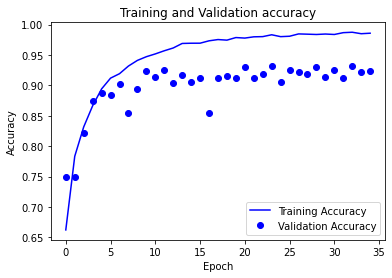

In [162]:
plt.plot(history.history['accuracy'], color='b', label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='', color='b', label = 'Validation Accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

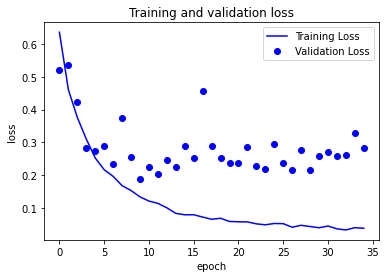

In [161]:
plt.plot(history.history['loss'], color='b', label = 'Training Loss')
plt.plot(history.history['val_loss'], marker='o', color='b', linestyle='', label = 'Validation Loss')
plt.legend()
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [20]:
print('Accuracy on the training data:')
print(model.evaluate(X_train, y_train)[1])

print('\nAccuracy on the test data:')
print(model.evaluate(X_test, y_test)[1])

Accuracy on the training data:


2022-01-27 21:00:51.257027: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2187000000 exceeds 10% of free system memory.


704/704 [==============================] - 249s 353ms/step - loss: 0.0306 - accuracy: 0.9918
0.9918222427368164

Accuracy on the test data:
79/79 [==============================] - 28s 350ms/step - loss: 0.2599 - accuracy: 0.9276
0.9276000261306763


### Let's get some batch predictions

The following steps are aimed to show 6 good predictions against 6 bad predictions.

- First we get batch predictions. These predictions are in decimals and we set a cutoff point of 0.5 to round up to 1 meaning that **all probabilities higher than 50% are considered as DOGS**. **All probabilities lower than 50% are categorised as CATS**
- 

In [85]:
preds = model.predict(X_test, batch_size=64)
#preds = np.round(preds)
preds = np.squeeze(preds, axis=(1,))

In [94]:
# assign indexes of errors and create a dataframe 
data = {'y_test': y_test, 'predicted_prob': preds}  
df = pd.DataFrame(data).reset_index(drop=True)
df['preds'] = df['predicted_prob'].round().astype(int)
df['error'] = np.where(df.y_test != df.preds, 1 , 0)
df = df.sort_values('error')
df

,y_test,predicted_prob,preds,error
0,1,0.998948,1,0
1634,1,0.997835,1,0
1635,1,0.999782,1,0
1636,1,0.993628,1,0
1637,1,1.000000,1,0
...,...,...,...,...
788,0,0.553055,1,1
1971,1,0.002245,0,1
2290,0,1.000000,1,1
801,0,0.859906,1,1


In [95]:
incorrect_classified = df.tail(6).index.values.tolist()
correct_classified = df.head(6).index.values.tolist()
list = correct_classified + incorrect_classified

In [96]:
correct_classified

[0, 1634, 1635, 1636, 1637, 1639]

In [102]:
df.loc[0, 'predicted_prob']

0.9989476

correctly classified


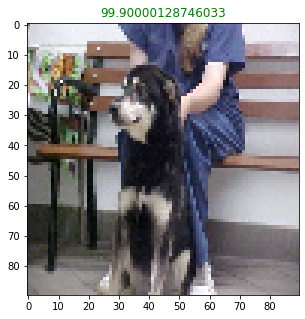

correctly classified


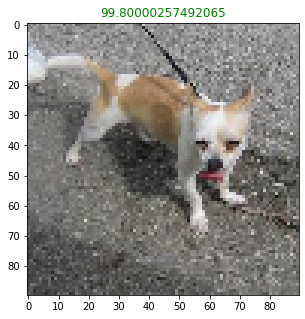

correctly classified


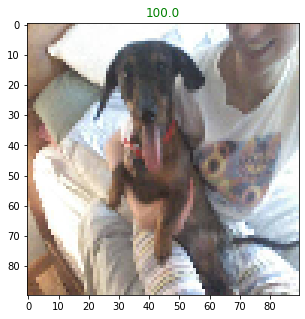

correctly classified


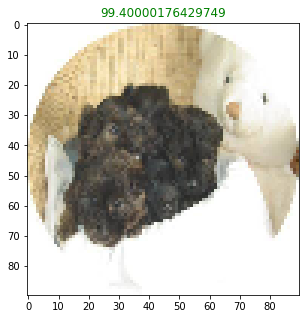

correctly classified


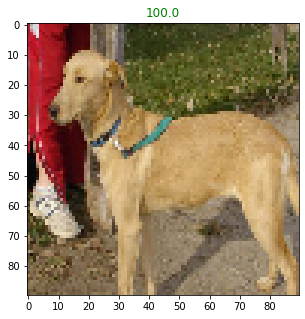

wrongly classified


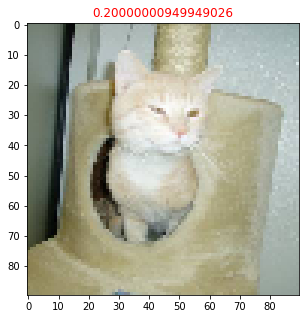

wrongly classified


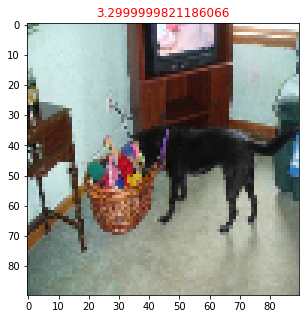

wrongly classified


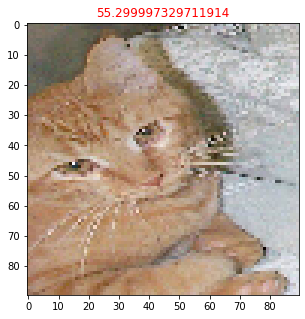

wrongly classified


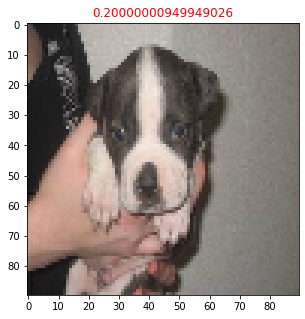

wrongly classified


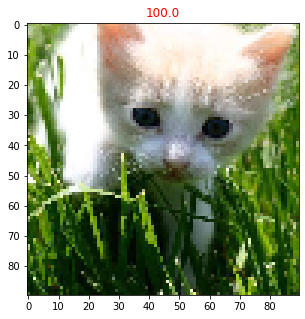

wrongly classified


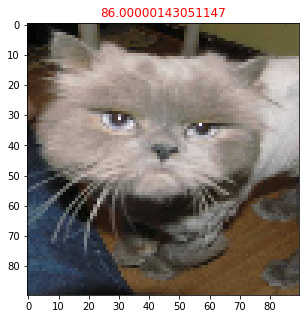

wrongly classified


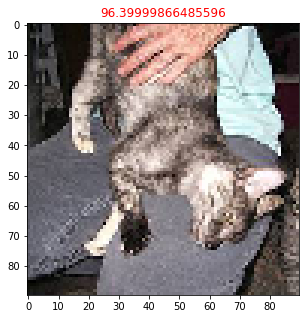

In [174]:
for idx, i in enumerate(list):
    
    plt.figure(figsize=(35,35))
    
    plt.subplot(6,6,6)
    
    plt.imshow(X_test[i] / 255)
    
    if idx < 5:
        
        print("correctly classified")
        
        prob = round(df.loc[i, 'predicted_prob'], 3)*100
            
        plt.title('{}'.format(prob), color='green')
        
    else:
        
        print("wrongly classified")
        
        prob = round(df.loc[i, 'predicted_prob'], 3)*100
            
        plt.title('{}'.format(prob), color='red')

    plt.show()

## Single Prediction: Gatina

In this section I'm going to use a picture of **Gatina**.  

Gatina was adopted by my cousin and his wife in Colombia, and then they moved to Spain and brought Gatina with them. She is a bit shy at the beggining, however, she likes to get close to humans looking for love. My family loves Gatina :)



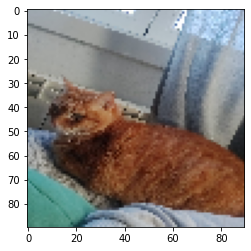

In [184]:
img = load_img('./gatina.jpg', target_size=(90, 90))
img_arr = img_to_array(img)
img_batch = np.expand_dims(img_arr, axis=0)
img_preprocessed = img_batch / 255
plt.imshow(img)

In [183]:
prediction = model.predict(img_preprocessed)[0][0]
if prediction >= 0.5:
    print('This CNN algorithm is {:.2%} sure this is a Dog'.format(prediction))
else: 
    print('This CNN algorithm is {:.2%} sure this is a Cat'.format(1-prediction))

This CNN algorithm is 97.66% sure this is a Cat
